# Sentiment Analysis

Our brain is full of biases, many gained through evolution. One of the most well-known is **choice bias**: if we have to choose, we are most likely to choose the positive option over a negative one (Ref).

Based on this observation, I suspect that during the game, the player—when given the choice of the next article to click on—will be biased toward articles that convey a positive sentiment, even if these articles are not optimal.

To prove this, I will follow these steps:

1. **Calculate Sentiment Values**  
   I will calculate the sentiment value for each article link name. I decided to use only the name and not the full article because, during the choice moment, the user has access only to this limited information.

2. **Categorize Articles**  
   Based on a threshold, I will categorize all articles into **neutral**, **negative**, and **positive** sentiment groups.

3. **Count Sentiments Per Path**  
   For each path, I will count how many **positive**, **negative**, and **neutral** articles it contains.

4. **Balance the Dataset**  
   To ensure balanced classes, I will downsample the dataset to equalize the number of finished and unfinished paths.

<!-- 5. **Path Length**  
   Finally, to account for the possibility that the length of the path could influence the number of positive and negative articles, this variable is also included in the model. -->

Finally, I will fit a logistic regression model using the counts of the three sentiment categories to predict path abandonment. As expected, after following all the steps of a proper machine learning pipeline, I observed that the coefficient for negative sentiment is significant (**p-value < 0.05**). This suggests that choosing negative articles is an important factor in path abandonment.

(See last cell for conclusion).


In [1]:
import pandas as pd
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
import nltk
nltk.download('sentiwordnet')
nltk.download('punkt')
import matplotlib.pyplot as plt
import ast
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
import pandas as pd
import statsmodels.api as sm
import os
from tqdm import tqdm
tqdm.pandas()

os.chdir("./../..")
print(os.getcwd())

SAVE_FOLDER = "data/output/sentiment_data"


[nltk_data] Downloading package sentiwordnet to
[nltk_data]     /home/gabri/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/gabri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


/home/gabri/Desktop/ADA/ada-2024-project-theadacuates


In [2]:
df = pd.read_csv("/home/gabri/Desktop/ADA/ada-2024-project-theadacuates/data/output/processed_data/articles_processed.csv")
df

,article_name,article_name_encoded,article_id
0,Áedán mac Gabráin,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,0
1,Åland,%C3%85land,1
2,Édouard Manet,%C3%89douard_Manet,2
3,Éire,%C3%89ire,3
4,Óengus I of the Picts,%C3%93engus_I_of_the_Picts,4
...,...,...,...
4599,Zionism,Zionism,4599
4600,Zirconium,Zirconium,4600
4601,Zoroaster,Zoroaster,4601
4602,Zuid-Gelders,Zuid-Gelders,4602


## Calcultate Sentiment Value for each Article
Value calculated using only the title and not the whole article.
The choice is based on the fact that people when choosing the nwxt article have access to only the title.


In [3]:
def get_sentiment_swn(text):
    words = word_tokenize(text)
    pos_score = 0
    neg_score = 0

    for word in words:
        synsets = list(swn.senti_synsets(word))
        if synsets:
            pos_score += synsets[0].pos_score()
            neg_score += synsets[0].neg_score()

    if pos_score > neg_score:
        return 'positive'
    elif neg_score > pos_score:
        return 'negative'
    else:
        return 'neutral'

df['sentiment_category'] = df['article_name'].apply(get_sentiment_swn)

df


,article_name,article_name_encoded,article_id,sentiment_category
0,Áedán mac Gabráin,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in,0,neutral
1,Åland,%C3%85land,1,neutral
2,Édouard Manet,%C3%89douard_Manet,2,neutral
3,Éire,%C3%89ire,3,neutral
4,Óengus I of the Picts,%C3%93engus_I_of_the_Picts,4,neutral
...,...,...,...,...
4599,Zionism,Zionism,4599,neutral
4600,Zirconium,Zirconium,4600,neutral
4601,Zoroaster,Zoroaster,4601,neutral
4602,Zuid-Gelders,Zuid-Gelders,4602,neutral


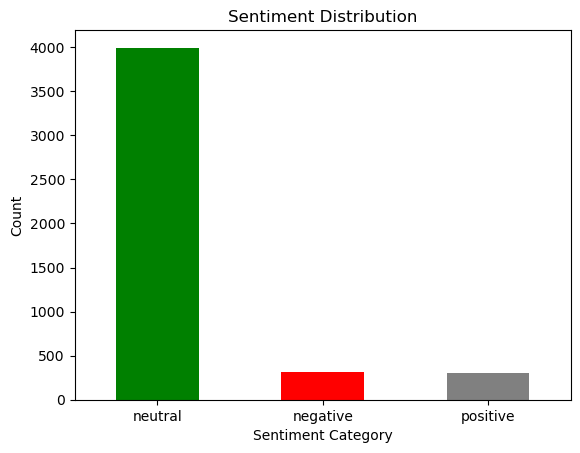

In [4]:
# Count the occurrences of each sentiment category
sentiment_counts = df['sentiment_category'].value_counts()

# Plot the bar chart
sentiment_counts.plot(kind='bar', color=['green', 'red', 'gray'], title="Sentiment Distribution")

# Set labels and title
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.xticks(rotation=0)  # Optional: Rotate the x-axis labels for better readability
plt.show()


## Add for each Path the number of article with specific sentiment

In [5]:
df_paths = pd.read_csv("/home/gabri/Desktop/ADA/ada-2024-project-theadacuates/data/output/processed_data/paths_processed.csv")
df_paths.head(2)

/tmp/ipykernel_102641/460625070.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  df_paths = pd.read_csv("/home/gabri/Desktop/ADA/ada-2024-project-theadacuates/data/output/processed_data/paths_processed.csv")


,hashed_ip,timestamp,duration,path,rating,path_list,source_link,target_link,finished,type_unfinished,n_click,n_back,date,click_rate,normalized_duration,freq_back,path_list_id,resolved_path_list_id,resolved_path_list_name
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,"['14th century', '15th century', '16th century...",14th century,African slave trade,True,NaN,9,0,2011-02-15 04:26:49,0.054217,18.444444,0.0,"[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[10, 12, 15, 3134, 377, 105, 128, 379, 143]","['14th century', '15th century', '16th century..."
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,"['14th century', 'Europe', 'Africa', 'Atlantic...",14th century,African slave trade,True,NaN,5,0,2012-08-12 08:36:52,0.056818,17.600000,0.0,"[10, 1433, 128, 379, 143]","[10, 1433, 128, 379, 143]","['14th century', 'Europe', 'Africa', 'Atlantic..."


In [6]:
# Function to count sentiment categories in the path
def count_sentiments_in_path(resolved_path_list_id):
    real_list = ast.literal_eval(resolved_path_list_id)
    sentiments = {'positive': 0, 'negative': 0, 'neutral': 0}
    for article in real_list:
        # Get the sentiment category for the article
        sentiment = df[df.article_id == article]["sentiment_category"].iloc[0]  # Extract the first value
        sentiments[sentiment] += 1
    return sentiments

# Apply the function to each path and create new columns for the counts
df_paths[['positive_count', 'negative_count', 'neutral_count']] = df_paths['resolved_path_list_id'].progress_apply(lambda path: pd.Series(count_sentiments_in_path(path)))

# Display the resulting dataframe
df_paths.head(3)



100%|██████████| 74114/74114 [01:45<00:00, 701.61it/s] 


,hashed_ip,timestamp,duration,path,rating,path_list,source_link,target_link,finished,type_unfinished,...,date,click_rate,normalized_duration,freq_back,path_list_id,resolved_path_list_id,resolved_path_list_name,positive_count,negative_count,neutral_count
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,"['14th century', '15th century', '16th century...",14th century,African slave trade,True,NaN,...,2011-02-15 04:26:49,0.054217,18.444444,0.0,"[10, 12, 15, 3134, 377, 105, 128, 379, 143]","[10, 12, 15, 3134, 377, 105, 128, 379, 143]","['14th century', '15th century', '16th century...",3,0,6
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,"['14th century', 'Europe', 'Africa', 'Atlantic...",14th century,African slave trade,True,NaN,...,2012-08-12 08:36:52,0.056818,17.600000,0.0,"[10, 1433, 128, 379, 143]","[10, 1433, 128, 379, 143]","['14th century', 'Europe', 'Africa', 'Atlantic...",1,0,4
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,"['14th century', 'Niger', 'Nigeria', 'British ...",14th century,African slave trade,True,NaN,...,2012-10-03 23:10:40,0.057971,17.250000,0.0,"[10, 2982, 2984, 694, 3755, 128, 379, 143]","[10, 2982, 2984, 694, 3755, 128, 379, 143]","['14th century', 'Niger', 'Nigeria', 'British ...",1,0,7


In [7]:
# Rebalance classes with dowsanplng

# Step 1: Check the current distribution of finished and unfinished paths
print(df_paths['finished'].value_counts())

# Step 2: Split the DataFrame into finished and unfinished paths
finished_paths = df_paths[df_paths['finished'] == 1]
unfinished_paths = df_paths[df_paths['finished'] == 0]

# Step 3: Rebalance the dataset
# Option 1: Undersample the majority class (if there are more finished paths)
min_count = min(finished_paths.shape[0], unfinished_paths.shape[0])

# Undersample both finished and unfinished paths to have an equal number of paths
finished_paths_balanced = finished_paths.sample(min_count, random_state=42)
unfinished_paths_balanced = unfinished_paths.sample(min_count, random_state=42)

# Combine the balanced datasets
df_balanced = pd.concat([finished_paths_balanced, unfinished_paths_balanced])

print(df_balanced.finished.value_counts())

finished
True     51280
False    22834
Name: count, dtype: int64
finished
True     22834
False    22834
Name: count, dtype: int64


In [8]:
# Save df with sentiment
df_balanced.to_csv("data/output/sentiment_data/paths_processed_sentiment.csv")


# Logistic Regression for Path Abandoment Prediction

In [9]:
df_paths_sentiment = pd.read_csv("data/output/sentiment_data/paths_processed_sentiment.csv")

In [10]:
# Separate features and target variable
X = df_paths_sentiment[['positive_count', 'negative_count', 'neutral_count']]  # You can add other features like 'duration', 'n_click', etc.
y = df_paths_sentiment['finished']

# Logistic Regression model
model = LogisticRegression()

# Perform cross-validation
cv_results = cross_validate(
    model, X, y, cv=10, scoring=['accuracy', 'precision', 'recall', 'f1'], return_train_score=True
)

# Display cross-validation metrics (mean ± std)
print("Cross-Validation Results:")
for metric in ['test_accuracy', 'test_precision', 'test_recall', 'test_f1']:
    mean = np.mean(cv_results[metric])  # Calculate mean
    std = np.std(cv_results[metric])  # Calculate standard deviation
    print(f"{metric}: {mean:.4f} ± {std:.4f}")


Cross-Validation Results:
test_accuracy: 0.5792 ± 0.0058
test_precision: 0.5989 ± 0.0074
test_recall: 0.4795 ± 0.0085
test_f1: 0.5326 ± 0.0072


In [11]:
# Add a constant to the model (intercept)
X = sm.add_constant(X)

# Fit a logistic regression model using statsmodels
model = sm.Logit(y, X)
result = model.fit(maxiter=1000)

# Get a summary of the regression results
print(result.summary())

# Display the coefficients, standard errors, and p-values for each feature
coefficients = result.params
std_errors = result.bse
z_scores = result.tvalues
p_values = result.pvalues

# Print detailed results for coefficients, std errors, z-scores, and p-values
print("\nDetailed Coefficients Information:")
for feature, coef, std_err, z_score, p_value in zip(X.columns, coefficients, std_errors, z_scores, p_values):
    print(f"{feature}: Coefficient = {coef:.4f}, Std Error = {std_err:.4f}, Z-score = {z_score:.4f}, P-value = {p_value:.4f}")

# Optionally, calculate confidence intervals for the coefficients
conf_int = result.conf_int()
print("\nConfidence Intervals for Coefficients:")
print(conf_int)


Optimization terminated successfully.
         Current function value: 0.684525
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:               finished   No. Observations:                45668
Model:                          Logit   Df Residuals:                    45664
Method:                           MLE   Df Model:                            3
Date:                Thu, 12 Dec 2024   Pseudo R-squ.:                 0.01244
Time:                        14:10:11   Log-Likelihood:                -31261.
converged:                       True   LL-Null:                       -31655.
Covariance Type:            nonrobust   LLR p-value:                2.222e-170
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.3594      0.017    -21.685      0.000      -0.392      -0.327
positive_count   

# Conclusion

Pepito, Pepito, don’t you see you’re climbing mirrors here? Indeed, your data preprocessing pipeline for the logistic regression model is well-structured, but basing your analysis solely on the coefficients makes no sense.

Firstly, the coefficient contradicts your hypothesis. It is **positive (+0.05)**, which means that as the number of negative articles increases, the probability of finishing the path also increases. This is the opposite of your assumption. Secondly, the model’s accuracy is **50%**, and with only two classes, this implies that the model is effectively guessing randomly. There is no meaningful information being captured in the negative or positive paths.

This observation aligns with previous findings where users searched for hub articles regardless of their sentiment. For instance, "WW2" is frequently part of finished paths despite being counted as conveying negative sentiment.

Lastly, even if your model had achieved better accuracy, I am skeptical about its reliability. In analyses like these, many variables can confound the results. For instance:
- There might not be an equal number of positive and negative articles on the current webpage to choose from.
- Negative articles might tend to appear at the bottom of the page or not accompanied by images.

Without addressing these potential biases, it’s impossible to make a fair comparison between positive and negative articles.

Pepito stop! You do not only know how to play wikispeedia, but you are also the worst dataanayst I have ever seen.
I recommend you also to play ADA course ;).
